# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Importing modules

In [212]:
! pip install sklearn numpy matplotlib imbalanced-learn statsmodels

import os
import zipfile
import statsmodels
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn import datasets as ds
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.multitest import multipletests

# Classifiers
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression

# Required and still not used:
#import torch
#import seaborn

Importing our data

In [213]:
cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

Exploring data part 1
- How many people have a normal ECG?
- How many people have an abnormal ECG?

In [214]:
# split labels from data
x = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y)  # current dataset has 146 nonzeros
total_normal_ECG = y.size -np.count_nonzero(y)  # current dataset has 681 zeros
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100  # 17.65 %

Splitting data into training and test data
- Subset training and test based on ratios
- Stratification
- Balancing
- Scaling
- Outer cross-validation -> moet nog gedaan worden!

In [215]:
# Split data
X_train, X_test_DO_NOT_FIT, y_train, y_test_DO_NOT_FIT = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
y_train_ab = y_train==1  # waarom maken we hier bools van? ipv 1 en 0 hebben we nu true en false
# X_test_DO_NOT_FIT and y_test_DO_NOT_FIT SHOULD NOT BE USED FOR FITTING!!

# Balance data
ros = RandomOverSampler(sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_train = X_resampled
y_train = y_resampled

# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test_scaled_DO_NOT_FIT = scaler.transform(X_test_DO_NOT_FIT)

X_train=pd.DataFrame(X_train)
X_test_scaled_DO_NOT_FIT = pd.DataFrame(X_test_scaled_DO_NOT_FIT)

620


Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [216]:
# Missing data
X_train = X_train.replace(0, np.nan)  # make all zeros to NaN
nan_count = X_train.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Delete missing data when > --% of feature of sample is missing
X_train = X_train.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
X_train = X_train.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in X_train.columns:
    X_train[column].fillna(X_train[column].median(), inplace=True)

Exploring data part 2
- Is the data normally distributed?

In [217]:
# Normally distributed
stat = []
p = []
for col in X_train.columns:
    if X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64':
        s, pv = shapiro(X_train[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)
print('Median p-value', statistics.median(p), 'Mean p-value', statistics.mean(p))

Median p-value 2.1019476964872256e-44 Mean p-value 5.253861268514743e-29


Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the upper and lower fence of that feature

In [218]:
# create a new dataframe to store the results
results = pd.DataFrame({'Column': X_train.columns, 'W': stat, 'p-value': p}) 
mean_p_value = results['p-value'].mean()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not
median_p_value = results['p-value'].median()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not

# Outliers: Tukey's fence 
k=3
fences=pd.DataFrame()
outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

for col in X_train.columns:
    q1, q3 = np.percentile(X_train[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
    for row in X_train.index:
        if X_train.loc[row, col] < lower_fence or X_train.loc[row, col] > upper_fence:
            outliers.loc[row, col] = True # mark the place as an outlier

row_count = (outliers == True).sum(axis=1)
col_count = (outliers == True).sum(axis=0)
total_count = row_count.sum() + col_count.sum()
print(f'The total outliers in dataset x is {total_count}')

# create a copy of x to modify
new_x = X_train.copy()

#replace outliers with maximum or minimun interquartile range of x by column
for col in outliers.columns:
    q3 = X_train.loc[outliers[col] == False, col].quantile(0.75) # 3rd quartile of column where outlier is False
    q1 = X_train.loc[outliers[col] == False, col].quantile(0.25) # 1st quartile of column where outlier is False
    iqr = q3 - q1 # interquartile range of column where outlier is False
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    new_x.loc[outliers[col] & (new_x[col] > upper_fence), col] = upper_fence # replace outliers with upper fence
    new_x.loc[outliers[col] & (new_x[col] < lower_fence), col] = lower_fence # replace outliers with lower fence

C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

The total outliers in dataset x is 590732


C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fences[col]=[lower_fence, upper_fence]
C:\Users\irisv\AppData\Local\Temp\ipykernel_3520\3304028950.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

## Preprocessing normally distrubtion check

In [220]:
# Normally distributed
stat = []
p = []
for col in new_x.columns:
    if new_x[col].dtype == 'float64' or new_x[col].dtype == 'int64':
        s, pv = shapiro(new_x[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)
print('Median p-value after preprocessing', statistics.median(p), 'Mean p-value after preprocessing', statistics.mean(p))

Median p-value 3.608133712921024e-31 Mean p-value 1.9453728774826132e-26


## Pipelines to be tested
- Pipeline 1 PCA_uni + RF 
- Pipeline 2 PCA_uni + SVM_linear
- Pipeline 3 PCA_uni + Bayes
- Pipeline 4 PCA_uni + Quadratic
- Pipeline 5 LASSO + RF
- Pipeline 6 PCA_uni + KNN
- Pipeline 7 LASSO + KNN


In [222]:
#change the x_train to the new_x
X_train = new_x.copy()
X_train_lasso = X_train.copy()

X_train_pl_1 = X_train.copy()
X_train_pl_2 = X_train.copy()
X_train_pl_3 = X_train.copy()
X_train_pl_4 = X_train.copy()
X_train_pl_5 = X_train.copy()
X_train_pl_6 = X_train.copy()
X_train_pl_7 = X_train.copy()

Function for PCA + univariate

In [227]:
def PCA_univariate(X_train, y_train):
    #Remove features with zero variance
    sel_vt = VarianceThreshold(threshold=0.0)
    X_vt = sel_vt.fit_transform(X_train, y_train)
    
    #PCA
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]
    n_features = min(n_samples, n_features)

    pca = PCA(n_components=n_features)            
    X_train = pca.fit_transform(X_train)

    #Univariate
    sel_kb = SelectKBest(f_classif, k='all')
    sel_kb.fit(X_train, y_train)
    p_values = sel_kb.pvalues_

    reject_fdr, pvals_fdr, _, _ = multipletests(pvals=p_values, alpha=0.05, method='fdr_bh')
    features_selected=np.array(np.where(reject_fdr)[0])
    print(features_selected.shape)
    X_train = X_train[:,features_selected]

    return X_train




Function for LASSO feature selection

In [230]:
def LASSO_feature(X_train_lasso, y_train):
    # Define the Lasso model
    lasso = Lasso()

    # Grid search
    alphas = np.logspace(-5, 1, 100)  # Define the grid of alpha values to search over
    grid_search = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5)
    grid_search.fit(X_train_lasso, y_train)
    best_alpha = grid_search.best_params_['alpha']

    # Create a new Lasso model using the best alpha value
    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train_lasso, y_train)

    # Get the coefficients of the Lasso model, find them and define the new X_train with less features
    coef = lasso.coef_
    selected_features = np.where(coef != 0)[0]
    X_train_lasso = X_train_lasso[selected_features]
    return X_train_lasso

Stukje code om LASSO aan te roepen in je pipeline:

In [231]:
# X_train_lasso = LASSO_feature(X_train_lasso,y_train)
# print(X_train_lasso.shape)

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.742e-02, tolerance: 1.992e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.223e-02, tolerance: 1.987e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.293e-02, toler

(1022, 1773)


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 2.555e-02
  model = cd_fast.enet_coordinate_descent(


## Learning curves using PCA and univariate
- Code is used for creating learning curves
- Code is commented after using the learning curves but kept for checking

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the n

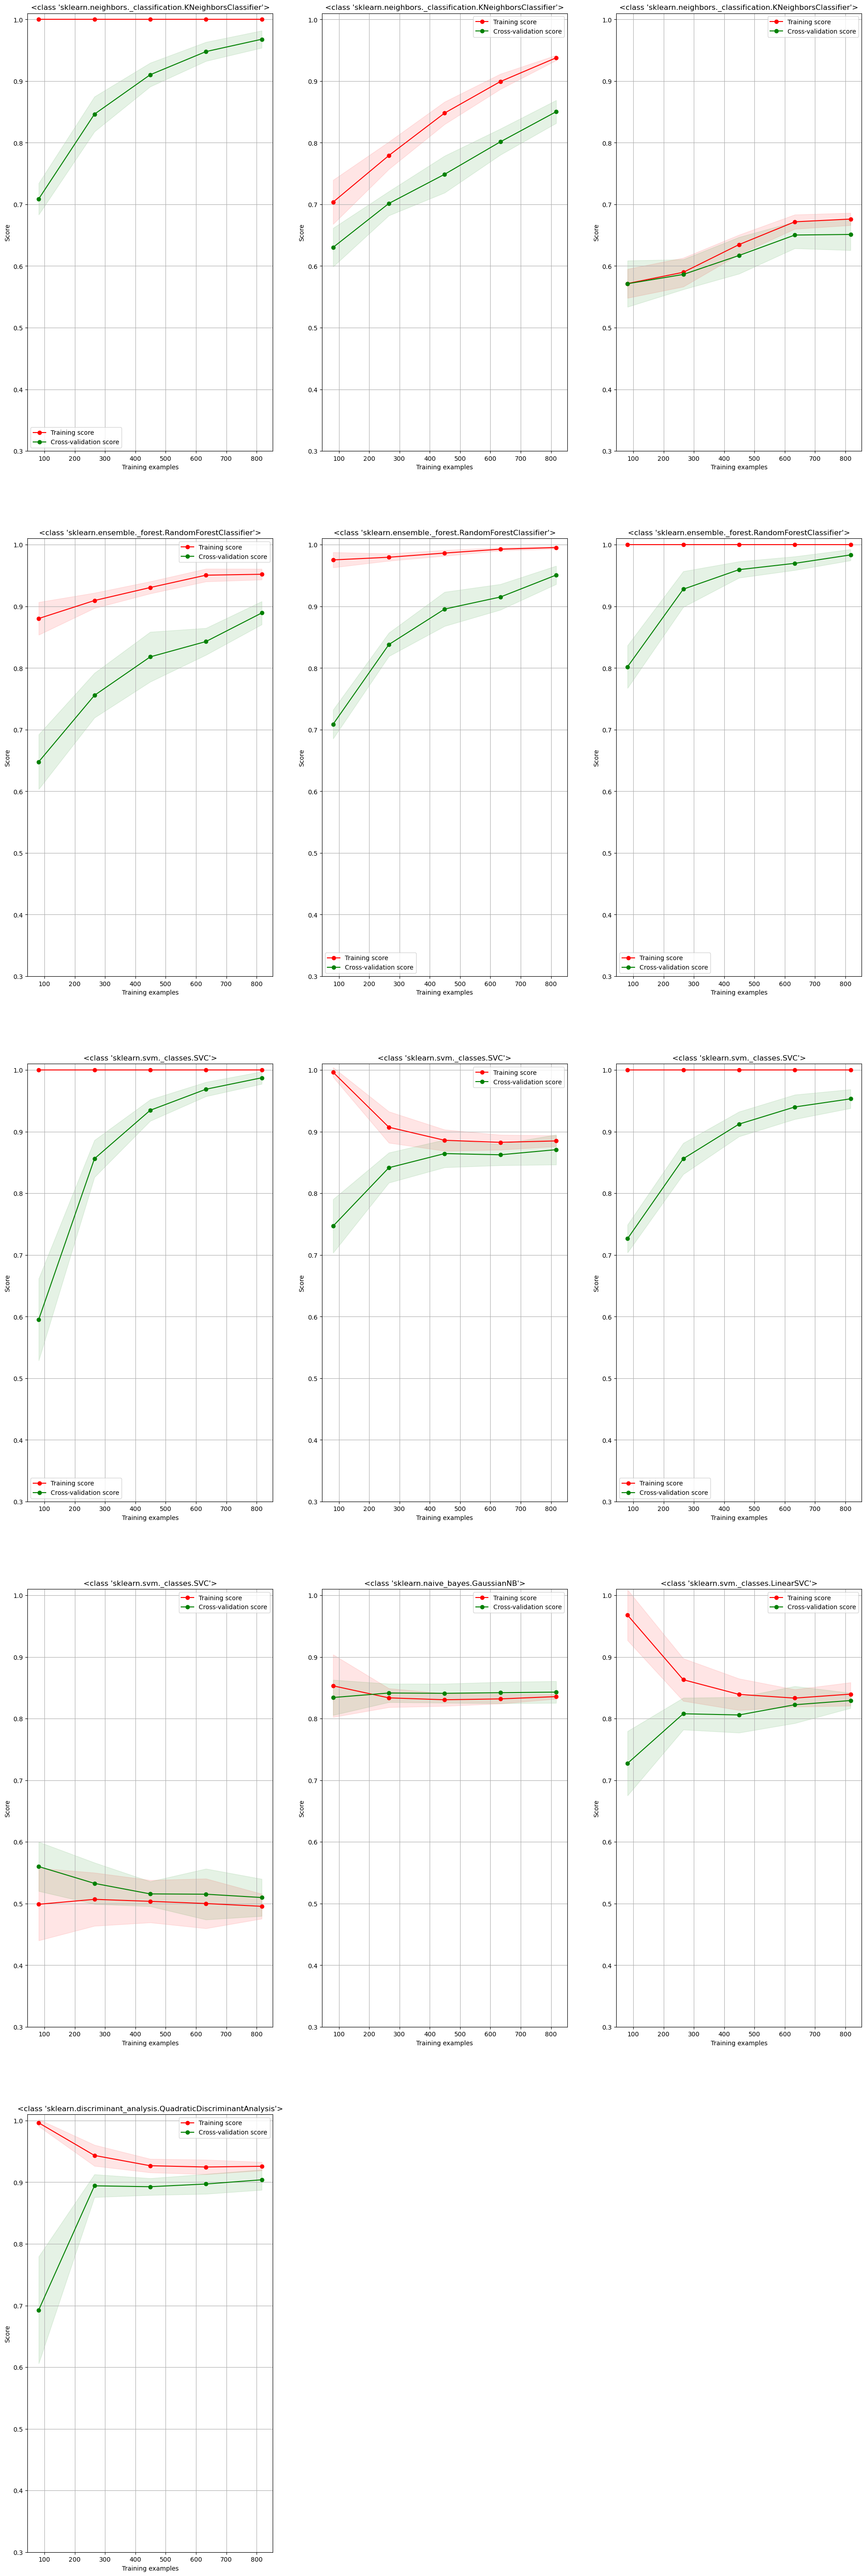

In [232]:
# def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     axes.set_title(title)
#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores  = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     # Plot learning curve
#     axes.grid()
#     axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes.legend(loc="best")

#     return plt

# clsfs_all = [neighbors.KNeighborsClassifier(n_neighbors=1), 
#          neighbors.KNeighborsClassifier(n_neighbors=5), 
#          neighbors.KNeighborsClassifier(n_neighbors=20), 
#          RandomForestClassifier(n_estimators=1, random_state=42),
#          RandomForestClassifier(n_estimators=5, random_state=42),
#          RandomForestClassifier(n_estimators=200, random_state=42),
#          SVC(kernel='rbf', C=10, gamma=0.1),
#          SVC(kernel='linear', C=10, gamma=0.1),
#          SVC(kernel='poly', C=10, gamma=0.1),
#          SVC(kernel='sigmoid', C=10, gamma=0.1),
#          GaussianNB(),
#          LinearRegression(),
#          QuadraticDiscriminantAnalysis()
#          ]

# num=0
# fig = plt.figure(figsize=(24,8*len(clsfs_all)))

# # Create a cross-validation object
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# # Now use the classifiers on all datasets
# for clf in clsfs_all:
#     title = str(type(clf))
#     ax = fig.add_subplot(7, 3, num + 1)
#     plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.3, 1.01), cv=cv)
#     num += 1

## Regularization of PCA + univariate for learning curves
- SVM rbf
- SVM poly
- RF: 1,5,20
- quadratic

(1022, 27)
(1022, 27)
(1022,)


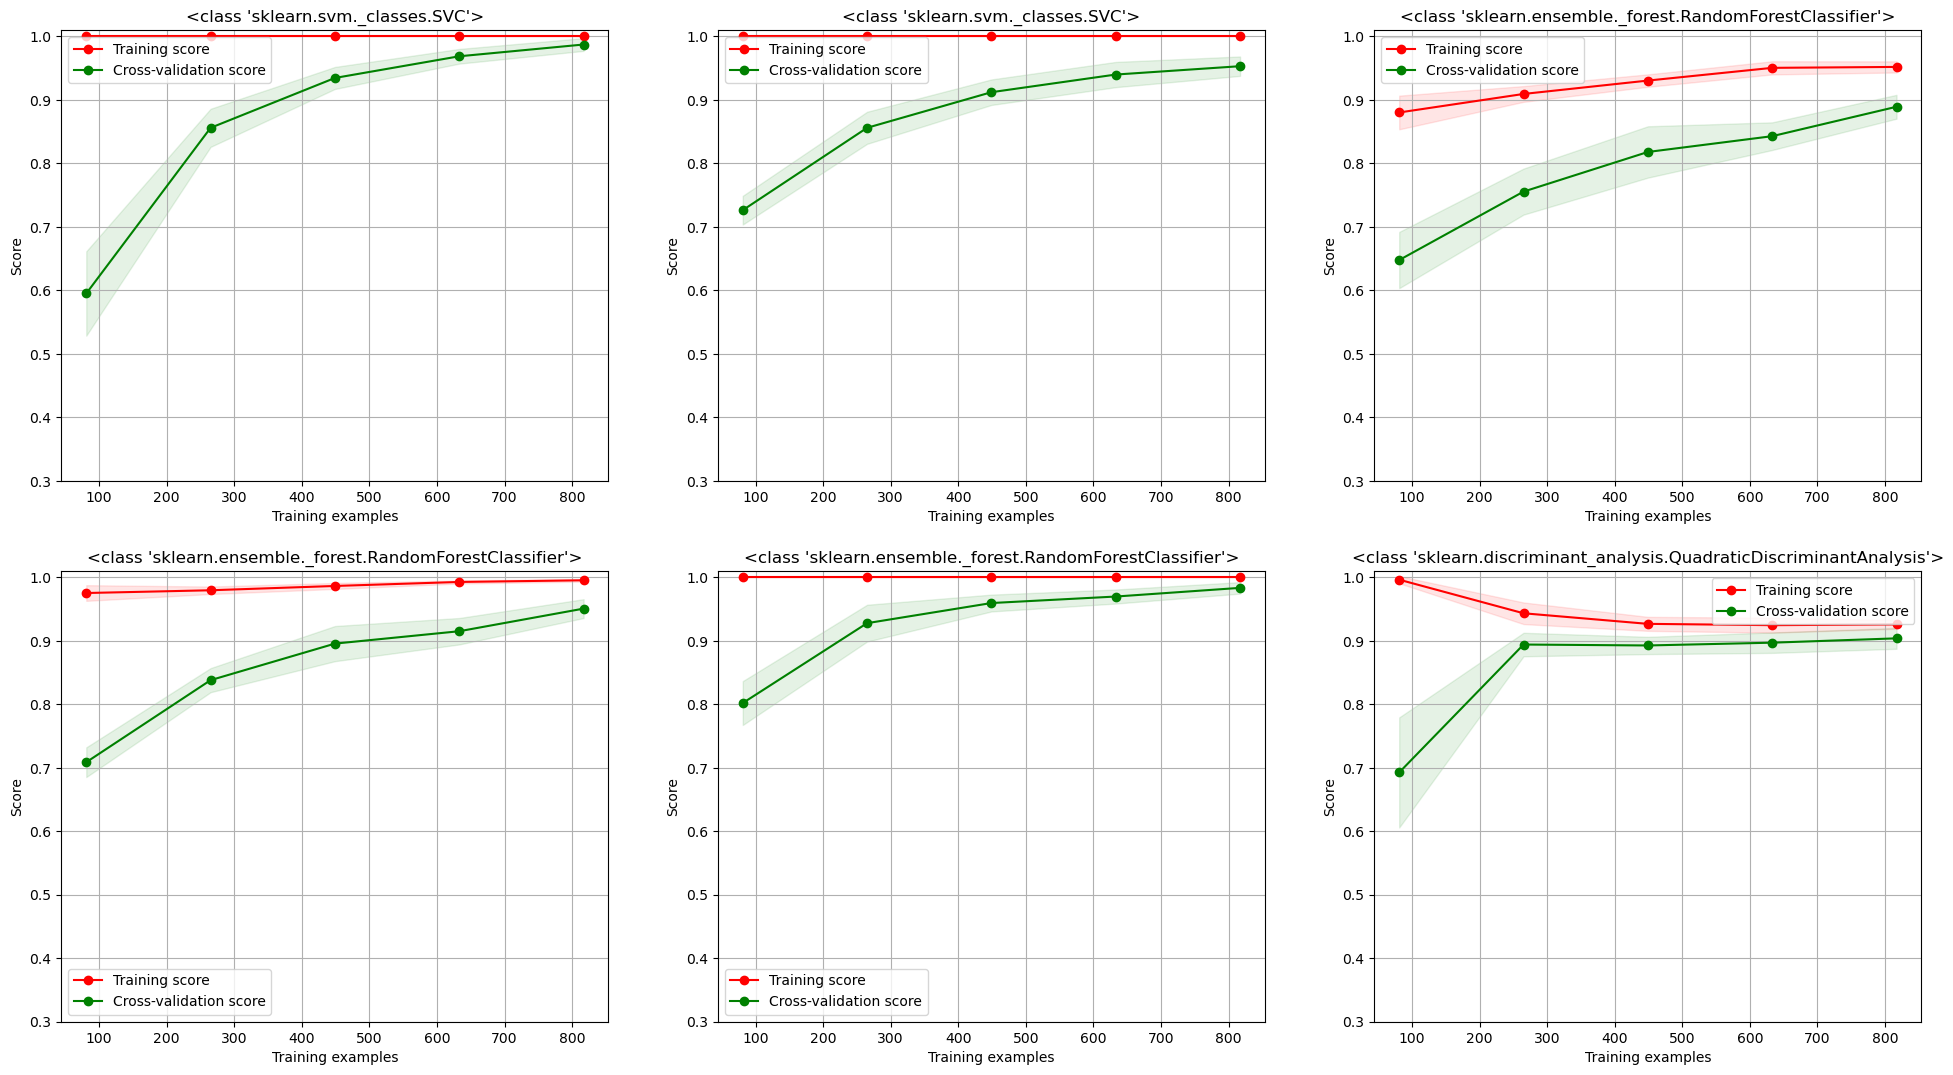

In [233]:
# # Define the Lasso model
# lasso2 = Lasso()
# # Define the grid of alpha values to search over
# alphas2 = np.logspace(-5, 1, 100)
# # Define the grid search
# grid_search2 = GridSearchCV(lasso2, param_grid={'alpha': alphas2}, cv=5)
# # Fit the grid search to your training data
# grid_search2.fit(X_train, y_train)
# # Get the best alpha value from the grid search
# best_alpha2 = grid_search2.best_params_['alpha']
# # Create a new Lasso model using the best alpha value
# lasso2 = Lasso(alpha=best_alpha2)
# # Fit the Lasso model to your training data
# lasso2.fit(X_train, y_train)
# # Get the coefficients of the Lasso model
# coef2 = lasso2.coef_
# # Get the indices of the selected features
# selected_features2 = np.where(coef2 != 0)[0]
# #X_train_regularization = X_train[selected_features2]
# X_train_regularization = X_train[:, selected_features2]
# #X_train_regularization = X_train[:,selected_features2[0,:]]

# print(X_train.shape)
# print(X_train_regularization.shape)
# print(y_train.shape)



# clsfs_regularization = [SVC(kernel='rbf', C=10, gamma=0.1),
#          SVC(kernel='poly', C=10, gamma=0.1),
#          RandomForestClassifier(n_estimators=1, random_state=42),
#          RandomForestClassifier(n_estimators=5, random_state=42),
#          RandomForestClassifier(n_estimators=200, random_state=42),
#          QuadraticDiscriminantAnalysis()]

# num=0
# fig = plt.figure(figsize=(24,8*len(clsfs_regularization)))

# # Create a cross-validation object
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# # Now use the classifiers on all datasets
# for clf in clsfs_regularization:
#     title = str(type(clf))
#     ax = fig.add_subplot(7, 3, num + 1)
#     plot_learning_curve(clf, title, X_train_regularization, y_train, ax, ylim=(0.3, 1.01), cv=cv)
#     num += 1


Learning curves using LASSO as feature selection

c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\irisv\miniconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the n

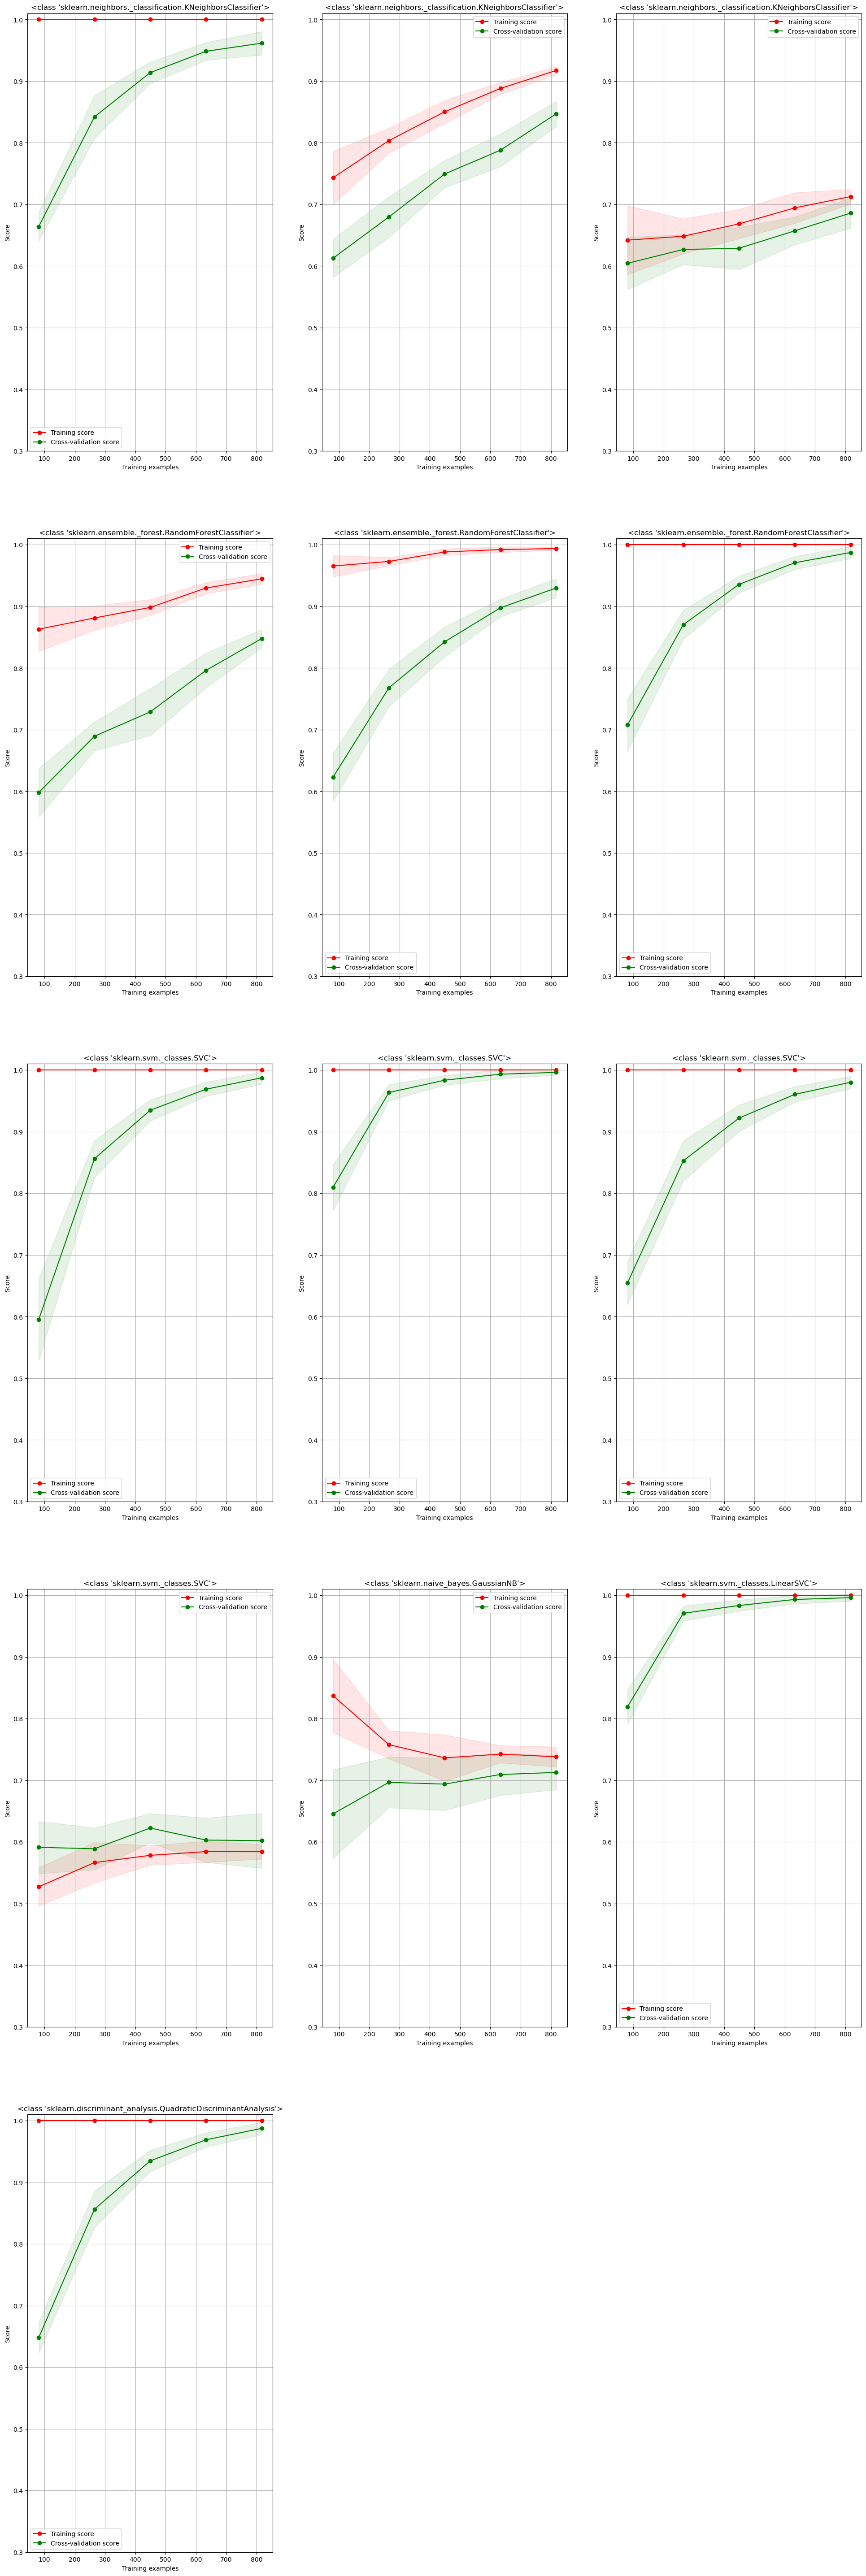

In [234]:
# num=0
# fig = plt.figure(figsize=(24,8*len(clsfs_all)))

# # Create a cross-validation object
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# # Now use the classifiers on all datasets
# for clf in clsfs_all:
#     title = str(type(clf))
#     ax = fig.add_subplot(7, 3, num + 1)
#     plot_learning_curve(clf, title, X_train_lasso, y_train, ax, ylim=(0.3, 1.01), cv=cv)
#     num += 1

# Hyperparameter tuning
- Pipeline 1 PCA_uni + RF 
- Pipeline 2 PCA_uni + SVM_linear
- Pipeline 3 PCA_uni + Bayes
- Pipeline 4 PCA_uni + Quadratic
- Pipeline 5 LASSO + RF
- Pipeline 6 PCA_uni + KNN
- Pipeline 7 LASSO + KNN



## Pipeline 1  PCA_uni + RF 



In [248]:
# Perform feature selection
X_train_pl_1 = PCA_univariate(X_train_pl_1, y_train)

# Hyperparameter tuning RandomForest classifier
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_pl_1, y_train)

print(rf_random.best_params_)

# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

# base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
# base_model.fit(X_train_pl_1, y_train)
# base_accuracy = evaluate(base_model, X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT)
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT)
# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc', 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_result_RF = grid_search.fit(X_train_pl_1, y_train)
grid_search.best_params_
best_grid = grid_search.best_estimator_
print(grid_search.best_params_)
print(best_grid)
print(f'The best accuracy score for the training dataset is {grid_result_RF.best_score_:.4f}')
# grid_accuracy = evaluate(best_grid, X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT)
# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


(27,)
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 288 candidates, totalling 864 fits


c:\Users\irisv\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan 

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=8)
The best accuracy score for the training dataset is nan


## Pipeline 2 PCA_uni + SVM_linear



In [237]:
# Check default values
X_train_pl_2 = PCA_univariate(X_train_pl_2,y_train)

svc = SVC()
params = svc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

# Run model pipeline 2
svc.fit(X_train_pl_2, y_train)

# List of C values
C_range_2 = np.logspace(-3, 1, 20)

# Define the search space
param_grid_2 = { 
    # Regularization parameter.
    "C": C_range_2,
    # Kernel type
    "kernel": ['linear'],
    }
# Set up score
scoring_2 = ['roc_auc']
# Set up the k-fold cross-validation
kfold_2 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Define grid search
grid_search_2 = GridSearchCV(estimator=svc, 
                           param_grid=param_grid_2, 
                           scoring=scoring_2, 
                           refit = 'roc_auc',
                           n_jobs=-1, 
                           cv=kfold_2, 
                           verbose=0)
# Fit grid search
grid_result_2 = grid_search_2.fit(X_train_pl_2, y_train)
# Print grid search summary
#print(grid_result_2)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result_2.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result_2.best_params_}')

(27,)
The list of values for C are [1.00000000e-03 1.62377674e-03 2.63665090e-03 4.28133240e-03
 6.95192796e-03 1.12883789e-02 1.83298071e-02 2.97635144e-02
 4.83293024e-02 7.84759970e-02 1.27427499e-01 2.06913808e-01
 3.35981829e-01 5.45559478e-01 8.85866790e-01 1.43844989e+00
 2.33572147e+00 3.79269019e+00 6.15848211e+00 1.00000000e+01]
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
                         'kernel': ['linear']},
             refit='roc_auc', scoring=['roc_auc'])
The best accuracy score for the training dataset is 0.923

## Pipeline 3 PCA_uni + Bayes

In [238]:
# optimizing var_smoothing parameter
X_train_pl_3 = PCA_univariate(X_train_pl_3,y_train)

best_estimator = []

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB()

# performing a grid search using 10-fold stratified cv
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_nb = GridSearchCV(gnb, param_grid_nb, cv=cv_10fold, scoring='roc_auc')
# fit the grid search onto the training data
grid_nb.fit(X_train_pl_3, y_train)

#find the best var_smoothing value
best_nb_model = grid_nb.best_estimator_
best_estimator = float(best_nb_model.var_smoothing)
print(grid_nb.best_estimator_)

# fit the GaussianNB with the optimal var_smoothing
gnb_best = GaussianNB(var_smoothing=best_estimator)
gnb_best.fit(X_train_pl_3,y_train)
y_pred = gnb_best.predict(X_train_pl_3)

if hasattr(gnb_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = gnb_best.predict_proba(X_train_pl_3)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')
# cv results
#pd.DataFrame(grid_nb.cv_results_)

(27,)
GaussianNB(var_smoothing=0.0001519911082952933)
The auc is 0.9176282259948452


## Pipeline 4 PCA_uni + Quadratic Discriminant Analysis
- QDA has no hyperparameter tuning

## Pipeline 5 LASSO + RF


## Pipeline 6 PCA_uni + KNN


In [ ]:
X_train_pl_6 = PCA_univariate(X_train_pl_6,y_train)

# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []
    
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Same as above
parameters = {"n_neighbors": list(range(1, 26, 2))}
knn = neighbors.KNeighborsClassifier()
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
grid_search.fit(X_train_pl_6, y_train)
    
# Get resulting classifier
clf = grid_search.best_estimator_
print(f'Best classifier: k={clf.n_neighbors}')

best_estimator = int(clf.n_neighbors)
print(clf)

# fit the k with the optimal 
knn_best = KNeighborsClassifier(best_estimator)
knn_best.fit(X_train_pl_6,y_train)
y_pred = knn_best.predict(X_train_pl_6)

if hasattr(knn_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = knn_best.predict_proba(X_train_pl_6)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')

## Pipeline 7 LASSO + KNN


In [245]:
#X_train_pl_7 = LASSO_feature(X_train_pl_7,y_train)

# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []
    
# Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# Same as above
parameters = {"n_neighbors": list(range(1, 26, 2))}
knn = neighbors.KNeighborsClassifier()
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
grid_search.fit(X_train_pl_7, y_train)
    
# Get resulting classifier
clf = grid_search.best_estimator_
print(f'Best classifier: k={clf.n_neighbors}')

best_estimator = int(clf.n_neighbors)
print(clf)

# fit the k with the optimal 
knn_best = KNeighborsClassifier(best_estimator)
knn_best.fit(X_train_pl_7,y_train)
y_pred = knn_best.predict(X_train_pl_7)

if hasattr(knn_best, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = knn_best.predict_proba(X_train_pl_7)[:, 1]
else:
    y_score = y_pred

auc=metrics.roc_auc_score(y_train, y_score)

print(f'The auc is {auc}')

Best classifier: k=3
KNeighborsClassifier(n_neighbors=3)
The auc is 0.999234071560694


In [240]:
## KNN hyperparameter tuning

# # Create a 20 fold stratified CV iterator
# cv_20fold = model_selection.StratifiedKFold(n_splits=10)
# results = []
# best_n_neighbors = []
    
# # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# # Same as above
# parameters = {"n_neighbors": list(range(1, 26, 2))}
# knn = neighbors.KNeighborsClassifier()
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
# grid_search.fit(X_train_pl_1, y_train)
    
# # Get resulting classifier
# clf = grid_search.best_estimator_
# print(f'Best classifier: k={clf.n_neighbors}')

# best_estimator = int(clf.n_neighbors)
# print(clf)

# # fit the k with the optimal 
# knn_best = KNeighborsClassifier(best_estimator)
# knn_best.fit(X_train_pl_1,y_train)
# y_pred = knn_best.predict(X_train_pl_1)

# if hasattr(knn_best, 'predict_proba'):
#     # The first column gives the probability for class = 0, so we take
#     # the second which gives the probability class = 1:
#         y_score = knn_best.predict_proba(X_train_pl_1)[:, 1]
# else:
#     y_score = y_pred

# auc=metrics.roc_auc_score(y_train, y_score)

# print(f'The auc is {auc}')

## Pipeline 5
LASSO

In [241]:

# # Create a 20 fold stratified CV iterator
# cv_20fold = model_selection.StratifiedKFold(n_splits=10)
# results = []
# best_n_neighbors = []
    
# # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# # Same as above
# parameters = {"n_neighbors": list(range(1, 26, 2))}
# knn = neighbors.KNeighborsClassifier()
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
# grid_search.fit(X_train_pl_5, y_train)
    
# # Get resulting classifier
# clf = grid_search.best_estimator_
# print(f'Best classifier: k={clf.n_neighbors}')

# best_estimator = int(clf.n_neighbors)
# print(clf)

# # fit the k with the optimal 
# knn_best = KNeighborsClassifier(best_estimator)
# knn_best.fit(X_train_pl_5,y_train)
# y_pred = knn_best.predict(X_train_pl_5)

# if hasattr(knn_best, 'predict_proba'):
#     # The first column gives the probability for class = 0, so we take
#     # the second which gives the probability class = 1:
#         y_score = knn_best.predict_proba(X_train_pl_5)[:, 1]
# else:
#     y_score = y_pred

# auc=metrics.roc_auc_score(y_train, y_score)

# print(f'The auc is {auc}')

# Gaussian hyperparameter tuning

## Pipeline 3
PCA/Univariate

In [242]:
# # optimizing var_smoothing parameter
# best_estimator = []

# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb = GaussianNB()

# # performing a grid search using 10-fold stratified cv
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_nb = GridSearchCV(gnb, param_grid_nb, cv=cv_10fold, scoring='roc_auc')
# # fit the grid search onto the training data
# grid_nb.fit(X_train_pl_3, y_train)

# #find the best var_smoothing value
# best_nb_model = grid_nb.best_estimator_
# best_estimator = float(best_nb_model.var_smoothing)
# print(grid_nb.best_estimator_)

# # fit the GaussianNB with the optimal var_smoothing
# gnb_best = GaussianNB(var_smoothing=best_estimator)
# gnb_best.fit(X_train_pl_3,y_train)
# y_pred = gnb_best.predict(X_train_pl_3)

# if hasattr(gnb_best, 'predict_proba'):
#     # The first column gives the probability for class = 0, so we take
#     # the second which gives the probability class = 1:
#         y_score = gnb_best.predict_proba(X_train_pl_3)[:, 1]
# else:
#     y_score = y_pred

# auc=metrics.roc_auc_score(y_train, y_score)

# print(f'The auc is {auc}')
# # cv results
# #pd.DataFrame(grid_nb.cv_results_)

## Pipeline 7
LASSO

In [243]:
# # optimizing var_smoothing parameter
# best_estimator = []

# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb = GaussianNB()

# # performing a grid search using 10-fold stratified cv
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_nb = GridSearchCV(gnb, param_grid_nb, cv=cv_10fold, scoring='roc_auc')
# # fit the grid search onto the training data
# grid_nb.fit(X_train_pl_7, y_train)

# #find the best var_smoothing value
# best_nb_model = grid_nb.best_estimator_
# best_estimator = float(best_nb_model.var_smoothing)
# print(grid_nb.best_estimator_)

# # fit the GaussianNB with the optimal var_smoothing
# gnb_best = GaussianNB(var_smoothing=best_estimator)
# gnb_best.fit(X_train_pl_7,y_train)
# y_pred = gnb_best.predict(X_train_pl_7)

# if hasattr(gnb_best, 'predict_proba'):
#     # The first column gives the probability for class = 0, so we take
#     # the second which gives the probability class = 1:
#         y_score = gnb_best.predict_proba(X_train_pl_7)[:, 1]
# else:
#     y_score = y_pred

# auc=metrics.roc_auc_score(y_train, y_score)

# print(f'The auc is {auc}')

# Support Vector Machine Hyperparameter tuning
- No gamma because that is only in 'rbf', 'poly' or 'sigmoid' and we only use 'linear'
- Tuning of C

## Pipeline 2 & 6

In [244]:
# # Check default values
# svc = SVC()
# params = svc.get_params()
# params_df = pd.DataFrame(params, index=[0])
# params_df.T

# # Run model pipeline 2
# svc.fit(X_train_pl_2, y_train)
# # Accuracy score
# # print(f'The accuracy score of the model is {svc.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')

# # List of C values
# C_range_2 = np.logspace(-3, 1, 20)
# print(f'The list of values for C are {C_range_2}')

# # Define the search space
# param_grid_2 = { 
#     # Regularization parameter.
#     "C": C_range_2,
#     # Kernel type
#     "kernel": ['linear'],
#     }
# # Set up score
# # scoring_2 = ['accuracy'] For using accuracy
# scoring_2 = ['roc_auc']
# # Set up the k-fold cross-validation
# kfold_2 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # Define grid search
# grid_search_2 = GridSearchCV(estimator=svc, 
#                            param_grid=param_grid_2, 
#                            scoring=scoring_2, 
#                            #refit='accuracy', 
#                            refit = 'roc_auc',
#                            n_jobs=-1, 
#                            cv=kfold_2, 
#                            verbose=0)
# # Fit grid search
# grid_result_2 = grid_search_2.fit(X_train_pl_2, y_train)
# # Print grid search summary
# print(grid_result_2)

# # Print the best accuracy score for the training dataset
# print(f'The best accuracy score for the training dataset is {grid_result_2.best_score_:.4f}')
# # Print the hyperparameters for the best score
# print(f'The best hyperparameters are {grid_result_2.best_params_}')
# # Print the best accuracy score for the testing dataset
# #print(f'The accuracy score for the testing dataset is {grid_search_2.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')
# # dit kan nog niet want teveel features omdat de selectie nog niet is toegepast op x_test, daarnaast mag het nog niet


# # Run model pipeline 6
# svc.fit(X_train_pl_6, y_train)
# # Accuracy score
# #print(f'The accuracy score of the model is {svc.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')

# # List of C values
# C_range_6 = np.logspace(-3, 1, 20)
# print(f'The list of values for C are {C_range_6}')

# # Define the search space
# param_grid_6 = { 
#     # Regularization parameter.
#     "C": C_range_6,
#     # Kernel type
#     "kernel": ['linear'],
# }
# # Set up score
# scoring_6 = ['roc_auc']
# # Set up the k-fold cross-validation
# kfold_6 = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# # Define grid search
# grid_search_6 = GridSearchCV(estimator=svc, 
#                            param_grid=param_grid_6, 
#                            scoring=scoring_6, 
#                            # refit='accuracy', 
#                            refit = 'roc_auc',
#                            n_jobs=-1, 
#                            cv=kfold_6, 
#                            verbose=0)
# # Fit grid search
# grid_result_6 = grid_search_6.fit(X_train_pl_6, y_train)
# # Print grid search summary
# print(grid_result_6)

# # Print the best accuracy score for the training dataset
# print(f'The best accuracy score for the training dataset is {grid_result_6.best_score_:.4f}')
# # Print the hyperparameters for the best score
# print(f'The best hyperparameters are {grid_result_6.best_params_}')
# # Print the best accuracy score for the testing dataset
# #print(f'The accuracy score for the testing dataset is {grid_search_6.score(X_test_scaled_DO_NOT_FIT, y_test_DO_NOT_FIT):.4f}')
# # dit kan nog niet want teveel features omdat de selectie nog niet is toegepast op x_test, daarnaast mag het nog niet


## Aantekeningen voor onszelf

In [ ]:
# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]



for clf in clsfs:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print('Misclassified: %d / %d' % ((y_train != y_pred).sum(), X_train.shape[0]))